<a href="https://colab.research.google.com/github/LaurenBassett/GroundsDetector/blob/main/M6_8_Assignment_2_Designing_CNN_Architecture_to_recognize_UVA_Historical_Landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing UVA landmarks with neural nets (70 pts)
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this assignment, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 70 points for this assignment plus 10 bonus points if (1) your classifier performs exceed 94% accuracy.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_assignment_2.ipynb

Best of luck, and have fun! 

# Load Packages

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from FirebaseStorage
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2022-10-17 00:41:15--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.135.95, 74.125.142.95, 74.125.195.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.135.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media.1’

dataset.zip?alt=med 100%[===================>] 378.77M   146MB/s    in 2.6s    

2022-10-17 00:41:18 (146 MB/s) - ‘dataset.zip?alt=media.1’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Archive:  /content/dataset.zip?alt=media
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 200; 
img_width = 200;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


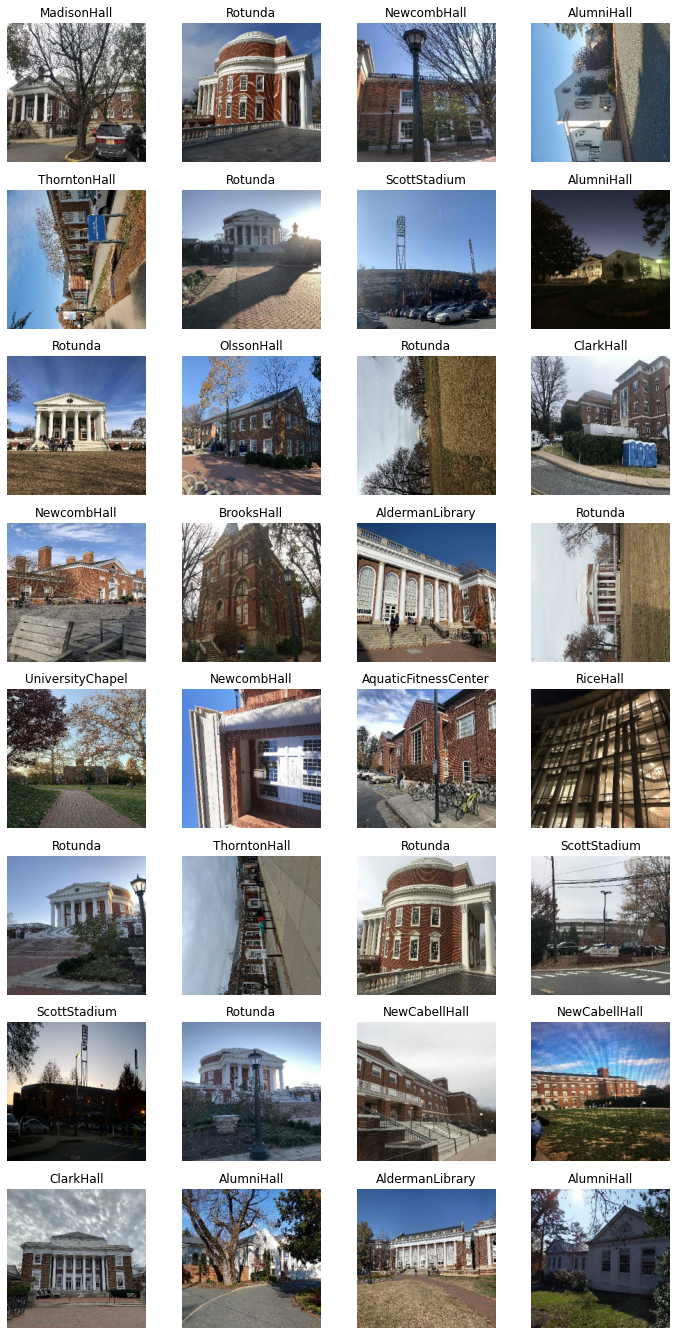

In [5]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks. 

Best of luck!


My first thought was to have some kind of classifier using the directory instead of the pre-written training and testing data. I thought that might be easier.  (It wasn't!), However, in the process I found this github repository written by Dr. Tirthajyoti Sarkar , that serves as my primary reference for how how many filters to include on each layer. I also looked at his optimizer, and had great success using it on this implementation. 

In this first iteration, I had an training accuracy of around 96%, but a validation accuracy around 70%. This told me I was overfitting the model. 

I tried a few ways to reduce the overfitting and have a better validation training accuracy.  
I added one Dropout layer, and removed one of the pooling layers. Removing a pooling layer helped slightly.  By doing this, I was able to raise my validation accuracy up to 75%. 


https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

Links: https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Keras_flow_from_directory.ipynb 

In [18]:
# YOUR CODE STARTS HERE

# 5 Convulutional 

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu', padding="SAME")

model = tf.keras.models.Sequential([

    DefaultConv2D(16, input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    DefaultConv2D(32),
    #tf.keras.layers.MaxPooling2D(2,2),
 
    DefaultConv2D(64),
    tf.keras.layers.MaxPooling2D(2,2),
    
    DefaultConv2D(64),
    tf.keras.layers.MaxPooling2D(2,2),
    
    DefaultConv2D(64),
    tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(18, activation='softmax')
])


In [13]:
from tensorflow.keras.optimizers import RMSprop

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer =  "nadam", #RMSprop(learning_rate=0.001),
              metrics = ['accuracy'])

In [20]:
model.fit(train_ds, epochs=25, validation_data=validation_ds)

Epoch 1/25
358/358 [==============================] - 26s 66ms/step - loss: 2.7305 - accuracy: 0.2247 - val_loss: 2.1758 - val_accuracy: 0.3486
Epoch 2/25
358/358 [==============================] - 23s 63ms/step - loss: 2.0366 - accuracy: 0.3944 - val_loss: 2.2219 - val_accuracy: 0.3213
Epoch 3/25
358/358 [==============================] - 23s 63ms/step - loss: 1.5640 - accuracy: 0.5376 - val_loss: 1.7766 - val_accuracy: 0.4883
Epoch 4/25
358/358 [==============================] - 23s 64ms/step - loss: 1.1530 - accuracy: 0.6561 - val_loss: 1.9081 - val_accuracy: 0.4554
Epoch 5/25
358/358 [==============================] - 23s 64ms/step - loss: 0.8892 - accuracy: 0.7286 - val_loss: 1.1953 - val_accuracy: 0.6783
Epoch 6/25
358/358 [==============================] - 24s 66ms/step - loss: 0.6837 - accuracy: 0.7911 - val_loss: 1.2957 - val_accuracy: 0.6591
Epoch 7/25
358/358 [==============================] - 23s 63ms/step - loss: 0.5379 - accuracy: 0.8357 - val_loss: 1.2306 - val_accuracy:

In [21]:
score = model.evaluate(validation_ds)



90/90 [==============================] - 4s 46ms/step - loss: 1.5992 - accuracy: 0.7448
